## Test Silent Drift
Questo blocco di codice iniziale serve come piattaforma di configurazione e caricamento per la valutazione dell'efficacia del modello LSTM Autoencoder nel rilevare attacchi Silent Drift.

1. **Preparazione degli Strumenti Analitici e di Misurazione.**
    Il codice importa un set di librerie focalizzate sulla valutazione della performance dove troviamo le metriche standard di cybersecurity e machine learning **(come l'Accuracy, Precision, Recall, F1-Score e la Curva ROC).**

2. **Ottimizzazione e Caricamento dei Componenti.**
   Viene eseguita l'ottimizzazione dell'hardware (GPU e Mixed Precision) per garantire che la fase di test sia rapida ed efficiente.
   
3. **Definizione del Contesto Operativo.**
   Vengono riconfermati i parametri strutturali del modello (WINDOW_SIZE, BATCH_SIZE e le quattro feature dinamiche) e, crucialmente, viene identificato il set di File di Test.
   Questi file sono la base sperimentale. Su queste traiettorie originali (mai viste dal modello), verrà iniettato l'attacco SIlent Drift. Il modello, che è stato addestrato solo sulla normalità, elaborerà queste traiettorie alterate.

In [24]:
import pandas as pd
import numpy as np
import glob
import os
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import pyarrow.parquet as pq
import tensorflow as tf
from tensorflow.keras import mixed_precision
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from mpl_toolkits.mplot3d import Axes3D

#CONFIGURAZIONE GPU
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        policy = mixed_precision.Policy('mixed_float16')
        mixed_precision.set_global_policy(policy)
        print("GPU e Mixed Precision Attivate.")
    except RuntimeError as e:
        print(e)

#ATH
INPUT_DIR = '../Pre-Elaborazione Dati/Dataset' 
SCALER_PATH = 'scaler.joblib' 
MODEL_PATH = 'lstm_autoencoder_best.keras' 

COLONNE_FEATURES = ['Latitude', 'Longitude', 'SOG', 'COG']
WINDOW_SIZE = 30  
BATCH_SIZE = 64 

# Carichiamo SOLO i file di TEST
all_files = sorted(glob.glob(os.path.join(INPUT_DIR, '*.parquet')))
TEST_FILES = all_files[20:24]
print(f"File di Test Caricati")

GPU e Mixed Precision Attivate.
File di Test Caricati


#####  Definizione delle Funzioni del Data Generator
Questo blocco definisce le due funzioni essenziali per trasformare i dati grezzi in sequenze pronte per il modello, mantenendo un'alta efficienza in termini di memoria (RAM)

In [20]:
def create_windows(data_np, window_size):
    windows = []
    for i in range(len(data_np) - window_size + 1):
        windows.append(data_np[i : i + window_size])
    return windows

def data_generator_v(file_paths, scaler, features, window_size, batch_size, shuffle_files=False):
    
    file_buffer = {} 
    window_buffer = [] 
    CHUNK_SIZE_ROWS = 500_000

    while True:
        if shuffle_files:
             # Shuffle disattivato forzatamente per garantire la sequenzialità
            shuffle_files = False 
            
        for file_path in file_paths:
            chunk_buffer = {}
            try:
                pf = pq.ParquetFile(file_path)
                for batch in pf.iter_batches(batch_size=CHUNK_SIZE_ROWS, columns=features + ['TrajectoryID']):
                    df_chunk = batch.to_pandas()
                    df_chunk[features] = scaler.transform(df_chunk[features])
                    next_chunk_buffer = {}
                    
                    for tid, group in df_chunk.groupby('TrajectoryID'):
                        if tid in chunk_buffer:
                            trajectory_data = pd.concat([chunk_buffer.pop(tid), group])
                        else:
                            trajectory_data = group
                        
                        if tid in file_buffer:
                            trajectory_data = pd.concat([file_buffer.pop(tid), trajectory_data])
                        
                        # Se la traiettoria tocca la fine del chunk, bufferizzala
                        if trajectory_data.iloc[-1].name == df_chunk.iloc[-1].name:
                            next_chunk_buffer[tid] = trajectory_data
                            continue 
                            
                        if len(trajectory_data) < window_size:
                            continue 
                            
                        trajectory_np = trajectory_data[features].to_numpy()
                        new_windows = create_windows(trajectory_np, window_size)
                        window_buffer.extend(new_windows)
                        
                        next_chunk_buffer[tid] = trajectory_data.iloc[-(window_size - 1):]

                        while len(window_buffer) >= batch_size:
                            batch_to_yield = window_buffer[:batch_size]
                            window_buffer = window_buffer[batch_size:]
                            yield (np.array(batch_to_yield), np.array(batch_to_yield))
                    
                    chunk_buffer = next_chunk_buffer
                file_buffer = chunk_buffer
            except Exception as e:
                print(f"\nErrore lettura {file_path}: {e}")
                continue
print("Funzioni definite")

Funzioni definite


##### Caricamento risorse

In [21]:
# Carica Scaler e Modello
scaler = joblib.load(SCALER_PATH)
model = tf.keras.models.load_model(MODEL_PATH)
print("Modello e Scaler caricati.")

# Inizializza il generatore pulito
test_gen = data_generator_v(TEST_FILES, scaler, COLONNE_FEATURES, WINDOW_SIZE, BATCH_SIZE, shuffle_files=False)

Modello e Scaler caricati.


#### Funzione attacco Silent Drift
La funzione `apply_silent_drift_attack` implementa un tipo di attacco che manipola la posizione di una nave introducendo un errore cumulativo e graduale (una "deriva") nel segnale GPS/AIS.
L'attacco Silent Drift cerca di mascherare la manipolazione inducendo una deriva lenta e costante della posizione dichiarata ($\text{Latitudine}$ e $\text{Longitudine}$) mentre i parametri dinamici interni ($\text{Velocità}$ e $\text{Rotta}$) rimangono inalterati.Poiché il cambiamento è graduale ad ogni timestep, il modello LSTM (e i sistemi di navigazione tradizionali) potrebbe impiegare più tempo ad accorgersi dell'incoerenza. Tuttavia, la mancanza di giustificazione cinematica (la deriva non è accompagnata da un cambio di velocità o rotta) alla fine espone la manipolazione.

La funzione `apply_silent_drift_attack` genera questo attacco introducendo un offset crescente in $\text{Latitudine}$ e $\text{Longitudine}$:
  1. **Copia e Tasso di Deriva:** Viene creata una copia del batch pulito `(batch_clean)`. Il parametro `drift_rate` ne definisce l'intensità per ogni timestep.
  2. **Creazione del Vettore di Drift:**
      * `steps = np.arange(batch_clean.shape[1])`: Crea una sequenza numerica da $0$ a $29$ (i 30 timestep della finestra).
      * `drift_vector = steps * drift_rate`: Questo crea un vettore in cui l'offset è cumulativo: è $0$ al primo timestep, $0.05$ al secondo, $0.10$ al terzo, e così via, simulando una deriva progressiva.
  3. **Iniezione della Deriva:** 
      * $\text{batch\_attacked}[:, :, 0] += \text{drift\_vector}$ ($\text{Latitudine}$)
      * $\text{batch\_attacked}[:, :, 1] += \text{drift\_vector}$ ($\text{Longitudine}$)
      * **Effetto:** Il codice applica questo vettore di deriva crescente a tutti i punti della traiettoria per simulare una deriva diagonale costante (verso Nord-Est in questo caso).


In [4]:
def apply_silent_drift_attack(batch_clean, drift_rate=0.05):

    """
        drift_rate: Intensità del drift (cumulativo per ogni step)
    """
    batch_attacked = batch_clean.copy()
    
    # Creiamo un vettore di drift crescente
    steps = np.arange(batch_clean.shape[1]) # 0 a 29
    drift_vector = steps * drift_rate
    
    # Applichiamo il drift a Latitudine (0) e Longitudine (1)
    # Simuliamo una deriva diagonale (Nord-Est)
    # Usiamo il broadcasting di numpy per applicarlo a tutto il batch
    
    # Lat = Lat + drift
    batch_attacked[:, :, 0] += drift_vector
    # Lon = Lon + drift
    batch_attacked[:, :, 1] += drift_vector
    
    return batch_attacked
print("Funzione di attacco Silent Drift definita.")

Funzione di attacco Silent Drift definita.


#### Creazione dataset misto
E' stato scelto di attaccare metà Dataset

In [5]:
X_test_mixed = []
y_true = [] 

NUM_BATCHES = 10000 

# Parametro di Drift: 0.05 è un drift medio sui dati normalizzati.
# Se è troppo basso, l'attacco è invisibile. Se troppo alto, è palese.
DRIFT_INTENSITY = 0.05 

for _ in range(NUM_BATCHES):
    try:
        clean_batch, _ = next(test_gen)
    except StopIteration:
        break
        
    # Creiamo l'attacco
    attacked_batch = apply_silent_drift_attack(clean_batch, drift_rate=DRIFT_INTENSITY)
    
    # Dividiamo a metà
    half = len(clean_batch) // 2
    
    # Aggiungiamo normali
    X_test_mixed.append(clean_batch[:half])
    y_true.extend([0] * half)
    
    # Aggiungiamo attaccati
    X_test_mixed.append(attacked_batch[half:])
    y_true.extend([1] * (len(clean_batch) - half))

X_test_mixed = np.concatenate(X_test_mixed)
y_true = np.array(y_true)

print(f"Dataset creato: {X_test_mixed.shape}")
print(f"Normali: {np.sum(y_true == 0)} | Attacchi Drift: {np.sum(y_true == 1)}")

Dataset creato: (640000, 30, 4)
Normali: 320000 | Attacchi Drift: 320000


#### Calcolo degli errori di rilevamento
Si sottopone il modello addestrato ai dati conteneni l'attacco Silent Drift. Come metrica chiave calcoliamo il $\text{MAE}$


In [13]:
# Predizione
reconstructions = model.predict(X_test_mixed, verbose=1)

# Calcolo Errore MAE
mae = np.mean(np.abs(X_test_mixed - reconstructions), axis=(1, 2))
print(f"Errori calcolati su tutti i {WINDOW_SIZE} step.")

20000/20000 ━━━━━━━━━━━━━━━━━━━━ 44s 2ms/step
Errori calcolati su tutti i 30 step.


#### Istogramma comparativo
Il codice genera un doppio istogramma che confronta le distribuzioni di errore ($\text{MAE}$) generate dal modello sul set misto:

 * **Distribuzione Normale :** Come nelle analisi precedenti, gli errori sono estremamente concentrati vicino allo zero ($\text{MAE} < 0.1$). Questo conferma la perfetta ricostruzione delle traiettorie pulite.

 * **Distribuzione Silent Drift:** Questa distribuzione è nettamente separata dalla distribuzione normale, ma a un livello di errore $\text{MAE}$ inferiore rispetto all'attacco cinematico (il picco è attorno a $0.4$, non a $0.9$ come nell'attacco precedente).

 * Sebbene l'errore sia inferiore (poiché la deriva è graduale, non un salto istantaneo), il modello è stato comunque in grado di rilevare l'incoerenza. La distanza tra la curva verde e la curva rossa è ampia, indicando che la differenziabilità è eccellente.

**Calcolo della Soglia Statistica**, che risulta essere uguale a $\mathbf{0.1385}$


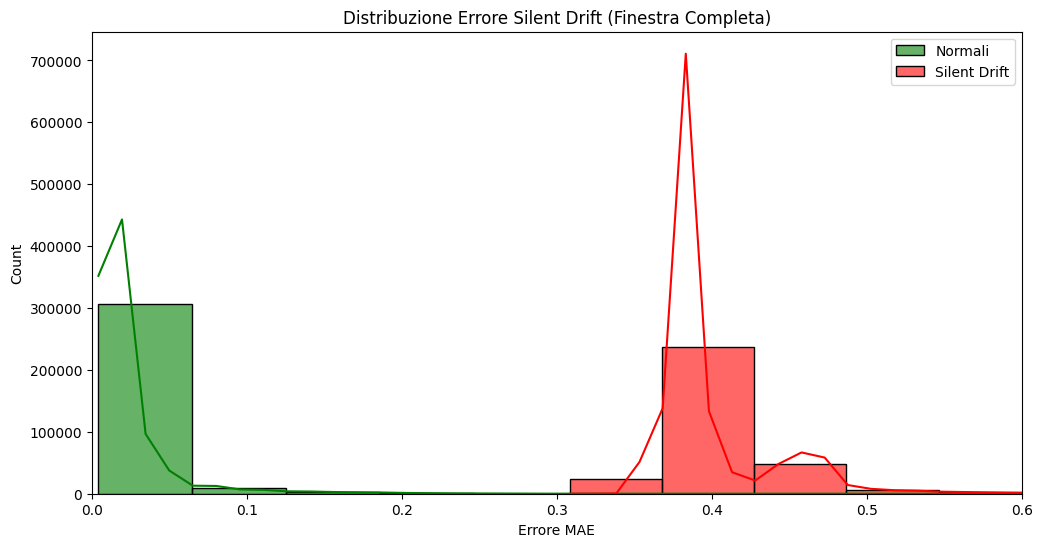

Soglia calcolata (Mean + 3*Std): 0.1385


In [16]:
# Istogramma
plt.figure(figsize=(12, 6))
sns.histplot(mae[y_true == 0], color='green', label='Normali', kde=True, bins=50, alpha=0.6)
sns.histplot(mae[y_true == 1], color='red', label='Silent Drift', kde=True, bins=50, alpha=0.6)

plt.xlim(0, 0.6)

plt.title(f"Distribuzione Errore Silent Drift (Finestra Completa)")
plt.xlabel("Errore MAE")
plt.legend()
plt.show()

#Calcolo Soglia
errori_normali = mae[y_true == 0]
THRESHOLD = np.mean(errori_normali) + 3 * np.std(errori_normali)
print(f"Soglia calcolata (Mean + 3*Std): {THRESHOLD:.4f}")

#### Calcolo metriche
1. **Classificazione e Calcolo delle Metriche**
   * Viene eseguita la classificazione binaria: se l'errore $\text{MAE}$ del campione supera la **THRESHOLD**, il sistema predice un Attacco (1); altrimenti, predice Normale (0).
   * **Metriche Calcolate:** 
     * $\mathbf{Accuracy} \approx 0.9937$ (99.37% di tutte le classificazioni sono corrette).
     * $\mathbf{Precision} \approx 0.9875$ (Quando il modello dice "Attacco", ha ragione nel 98.75% dei casi).
     * $\mathbf{Recall} = 1.0000$ (Il modello ha trovato il 100% di tutti gli attacchi reali presenti nel set).
     * $\mathbf{F1-Score} \approx 0.9937$ (La media armonica di Precision e Recall, un ottimo indicatore della performance complessiva).

2. **Analisi della Matrice di Confusione**
   * **True Positives (320,000):** Il modello ha identificato correttamente tutti i campioni che contenevano l'attacco Silent Drift.
   * **True Negatives (315,939):** Il modello ha classificato correttamente la stragrande maggioranza dei campioni normali.
   * **False Negatives (0):** Non c'è stato nessun falso negativo. 
   * **False Positives (4,061):** Ci sono stati 4,061 falsi positivi (traiettorie normali classificate erroneamente come attacco). Questo corrisponde allo $\mathbf{0.63\%}$ dei campioni normali, in linea con l'aspettativa statistica di una soglia $3\sigma$ (dove si aspetta che circa lo $0.3\%$ cada fuori).

Accuracy:  0.9937
Precision: 0.9875
Recall:    1.0000
F1-Score:  0.9937


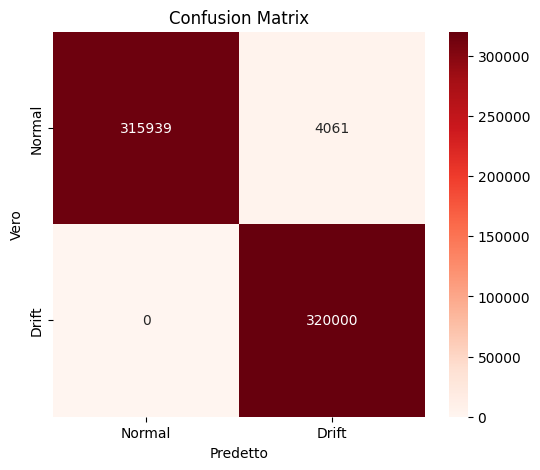

In [17]:
# Classificazione
y_pred = (mae > THRESHOLD).astype(int)

print(f"Accuracy:  {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred):.4f}")
print(f"Recall:    {recall_score(y_true, y_pred):.4f}")
print(f"F1-Score:  {f1_score(y_true, y_pred):.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=['Normal', 'Drift'], yticklabels=['Normal', 'Drift'])
plt.title("Confusion Matrix")
plt.ylabel("Vero")
plt.xlabel("Predetto")
plt.show()

#### Visualizzazione di un singolo attacco
Questo blocco di codice conclude l'analisi visualizzando il risultato dell'attacco Silent Drift in uno spazio tridimensionale che include il tempo. L'obiettivo è mostrare in modo intuitivo come il modello LSTM reagisce all'errore di deriva graduale.

1. **Preparazione all'esperimento**
   * **Iniezione Attacco:** Una singola traiettoria pulita viene estratta e l'attacco Silent Drift viene applicato, introducendo una deriva progressiva (la posizione si sposta costantemente e in modo crescente nel tempo).
   * **Inferenza:** Il modello LSTM Autoencoder esegue la predizione sulla sequenza alterata per produrre la ricostruzione `(traj_recon)`.

2. **Visualizzazione 3D (Spazio + Tempo)**
   * **La linea blu rappresenta l'Input (Deriva Costante)**. Nello spazio 3D, appare come una linea retta quasi perfetta che si muove uniformemente nello spazio mentre il tempo (asse $Z$) avanza. Questa traiettoria è cinematicamente impossibile perché non c'è nessun cambio di velocità o rotta che giustifichi un movimento di deriva così coerente e costante rispetto a dove la nave dovrebbe essere. 
   * **La linea rossa rappresenta il tentativo di ricostruzione del modello.** Invece di seguire la linea retta e impossibile dell'input, la ricostruzione dell'AI mostra un movimento irregolare e frastagliato. Quindi, il modello, incapace di replicare una traiettoria fisicamente non sensata, tenta disperatamente di "piegare" l'output verso la normalità che ha appreso, generando un percorso che è al contempo coerente con i vincoli cinematici ma che non assomiglia all'input.



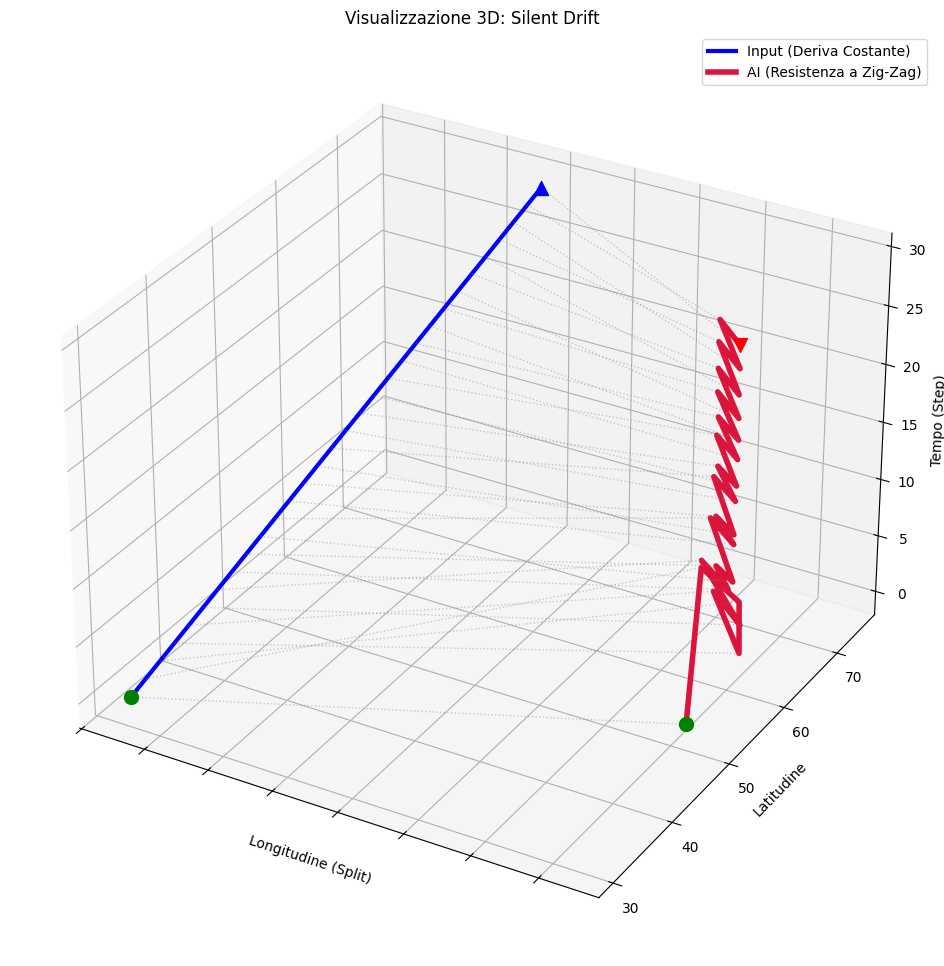

In [25]:
try:
    clean_batch, _ = next(test_gen)
except StopIteration:
    # Ricarica il generatore se è finito
    test_gen = data_generator_v(TEST_FILES, scaler, COLONNE_FEATURES, WINDOW_SIZE, BATCH_SIZE)
    clean_batch, _ = next(test_gen)

drift_batch = apply_silent_drift_attack(clean_batch, drift_rate=0.20)
pred_batch = model.predict(drift_batch, verbose=0)

idx = 0
traj_input = drift_batch[idx] 
traj_recon = pred_batch[idx]  

# Denormalizziamo
traj_input_real = scaler.inverse_transform(traj_input)
traj_recon_real = scaler.inverse_transform(traj_recon)

# Coordinate
lat_in, lon_in = traj_input_real[:, 0], traj_input_real[:, 1]
lat_out, lon_out = traj_recon_real[:, 0], traj_recon_real[:, 1]
time_steps = np.arange(WINDOW_SIZE)

# Offset per separare le rotte (Split View)
offset_lon = (np.max(lon_in) - np.min(lon_in)) * 2.0 
if offset_lon < 0.05: offset_lon = 0.05
lon_out_shifted = lon_out + offset_lon

# PLOT 3D FOCALIZZATO SULLA SERPENTINA
fig = plt.figure(figsize=(14, 12))
ax = fig.add_subplot(111, projection='3d')

# 1. Traccia Input (Blu)
ax.plot(lon_in, lat_in, time_steps, color='blue', linewidth=3, label='Input (Deriva Costante)')
ax.scatter(lon_in[0], lat_in[0], 0, color='green', s=100)
ax.scatter(lon_in[-1], lat_in[-1], 29, color='blue', s=100, marker='^')

# 2. Traccia AI (Rossa)
ax.plot(lon_out_shifted, lat_out, time_steps, color='crimson', linewidth=4, linestyle='-', label='AI (Resistenza a Zig-Zag)')
ax.scatter(lon_out_shifted[0], lat_out[0], 0, color='green', s=100)
ax.scatter(lon_out_shifted[-1], lat_out[-1], 29, color='red', s=100, marker='v')

# 3. Connessioni Neutre (Grigie)
for t in range(WINDOW_SIZE):
    ax.plot([lon_in[t], lon_out_shifted[t]], 
            [lat_in[t], lat_out[t]], 
            [t, t], 
            color='gray', linewidth=1, alpha=0.4, linestyle=':')

# Etichette
ax.set_xlabel('Longitudine (Split)')
ax.set_ylabel('Latitudine')
ax.set_zlabel('Tempo (Step)')
ax.set_title('Visualizzazione 3D: Silent Drift')

# Rimuoviamo i tick X per pulizia
ax.set_xticklabels([])

# Vista ottimale
ax.view_init(elev=30, azim=-60)
ax.legend()

plt.show()